<a href="https://colab.research.google.com/github/A-Midhat/Recommender_system_MF/blob/main/Final_Recommender_system(25m).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part1

##Downloading the Movielens 32m dataset

In [11]:
!wget https://files.grouplens.org/datasets/movielens/ml-25m.zip
!unzip ml-25m.zip

--2024-10-31 20:09:59--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.zip          100%[===================>] 249.84M  58.8MB/s    in 4.7s    

2024-10-31 20:10:04 (53.1 MB/s) - ‘ml-25m.zip’ saved [261978986/261978986]

Archive:  ml-25m.zip
   creating: ml-25m/
  inflating: ml-25m/tags.csv         
  inflating: ml-25m/links.csv        
  inflating: ml-25m/README.txt       
  inflating: ml-25m/ratings.csv      
  inflating: ml-25m/genome-tags.csv  
  inflating: ml-25m/genome-scores.csv  
  inflating: ml-25m/movies.csv       


In [3]:
# !wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
# !unzip ml-latest-small.zip

##Import libs

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import Counter


##Creating sub dataset of 100k

In [13]:
ratings = pd.read_csv("/content/ml-25m/ratings.csv")
# ratings.head()


##Processing the dataset of 100k

In [14]:
with open("/content/ml-25m/ratings.csv", "r") as file:
  next(file)
  ratings_data = []
  for line in file:
    fields = line.strip().split(",")
    user_id = int(fields[0])
    movie_id = int(fields[1])
    rating = float(fields[2])
    ts = fields[3]

    ratings_data.append((user_id, movie_id, rating, ts))

##Mapping users ids into indices and vise versa

In [15]:
user_to_id, id_to_user = {}, []  # Maps user IDs <-> indices
movie_to_id, id_to_movie = {}, []  # Maps movie IDs <-> indices

# Map unique user IDs to indices
for userid, _, _, _ in ratings_data:
    if userid not in user_to_id:
        user_to_id[userid] = len(user_to_id)
        id_to_user.append(userid)

# Map unique movie IDs to indices
for _, movieid, _, _ in ratings_data:
    if movieid not in movie_to_id:
        movie_to_id[movieid] = len(movie_to_id)
        id_to_movie.append(movieid)


In [8]:
len(id_to_user), len(id_to_movie)

(162541, 59047)

##Creating ds for users/movies containg a list of all users/movies and there movies_ids/user_ids and ratings

In [16]:
# Total numbers of users/movies
M = len(id_to_user)
N = len(id_to_movie)

users_data = [[] for _ in range(M)]
movies_data = [[] for _ in range(N)]

for user_id, movie_id, rating, _ in ratings_data:
  user_index = user_to_id[user_id]
  users_data[user_index].append((movie_id, rating))

  movie_index = movie_to_id[movie_id]
  movies_data[movie_index].append((user_id, rating))


In [10]:
M

162541

##power law plot

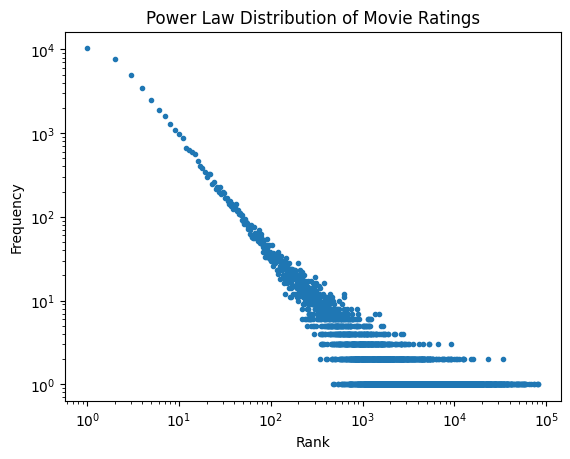

In [11]:
# ratings_list = [len(movie_data) for movie_id, movie_data in enumerate(movies_data)]

# ratings_list_dict = Counter(ratings_list)

# plt.loglog(ratings_list_dict.keys(), ratings_list_dict.values(), ".")
# plt.ylabel("Frequency")
# plt.xlabel("Rank")
# plt.title("Power Law Distribution of Movie Ratings")
# plt.show()

#Part2

##train_test_Split()

In [17]:
def split(users_data, movies_data, test_ratio=0.1):
    M = len(users_data)
    N = len(movies_data)

    users_data_train = [[] for _ in range(M)]
    users_data_test = [[] for _ in range(M)]
    movies_data_train = [[] for _ in range(N)]
    movies_data_test = [[] for _ in range(N)]

    for user_id, user_data in enumerate(users_data):
        for movie_rating in user_data:
            rand_val = np.random.rand()
            if rand_val > test_ratio:
                # Train set
                users_data_train[user_id].append(movie_rating)

                # placeholder for missing test entries
                users_data_test[user_id].append(())
            else:
                # Test set
                users_data_test[user_id].append(movie_rating)

                # placeholder for missing train entries
                users_data_train[user_id].append(())

    for movie_id, movie_row in enumerate(movies_data):
      for user_rating in movie_row:
        rand_val = np.random.rand()
        if rand_val>test_ratio:
          movies_data_train[movie_id].append(user_rating)
          movies_data_test[movie_id].append(())
        else:
          movies_data_test[movie_id].append(user_rating)
          movies_data_train[movie_id].append(())
    return users_data_train, users_data_test, movies_data_train, movies_data_test


##Initializing biases with zeros

In [18]:
# init biases
def init_biases(users_data, movies_data):
  user_biases = np.zeros(len(users_data))
  movie_biases= np.zeros(len(movies_data))
  return user_biases, movie_biases


##User bisaes update functions

In [19]:
# def update_user_biases(user_id, data_by_user, b_user, b_movie, lambda_, gamma):
#   no_movies_rated_by_user = 0 # 1
#   num = 0
#   for entry in data_by_user[user_id]:
#     if len(entry)==2:
#       no_movies_rated_by_user = no_movies_rated_by_user + 1

#       movie_id, ratings= entry

#       movie_index = movie_to_id[movie_id]

#       num+=(ratings - b_movie[movie_index])
#     else:
#       continue
#   dom = (lambda_*no_movies_rated_by_user)+ gamma

#   b_user[user_id] = lambda_*(num/dom)



# def update_all_user_biases(data_by_user, b_user, b_movie, lambda_, gamma):
#   for user_id in range(len(data_by_user)):
#     update_user_biases(user_id, data_by_user, b_user, b_movie, lambda_, gamma)
#   return b_user

In [20]:
# so at each one iteration it updates user_m and U[m] only and then it goes to tthe next user
def update_user_biases(user_id, users_data, user_biases, movie_biases, lambda_=0.1, gamma=0.01 ):

  # for user_id, user_data in enumerate(users_data):
    n = 0 # Number of movies rated by user
    error = 0
    for movie_rating in users_data[user_id]:
      if movie_rating: # empty

        n +=1
        movie_id, rating = movie_rating
        movie_index = movie_to_id[movie_id]
        error+=(rating - movie_biases[movie_index])

    regularization_term = (lambda_*n)+ gamma
    user_biases[user_id] = lambda_*(error/regularization_term)
  # return user_biases

##Movies bisaes update functions

In [21]:
# def update_movie_biases(movie_id, data_by_movie, b_user, b_movie, lambda_, gamma):
#   no_users_rated_movie = 0
#   num = 0
#   for entry in data_by_movie[movie_id]: # how to handle empty tuples ???
#     if len(entry)==2:
#       no_users_rated_movie = no_users_rated_movie + 1
#       user_id, ratings = entry
#       num+=(ratings - b_user[user_to_id[user_id]]) #**user_to_id[user_id]** calc numerator # fixed by mapping large mid to simpler mid (movie_to_id)
#     else:
#       continue
#   dom = (lambda_*no_users_rated_movie)+ gamma

#   b_movie[movie_id] = lambda_*(num/dom)

# def update_all_movie_biases(data_by_movie, b_user, b_movie, lambda_, gamma):
#   for movie_id in range(len(data_by_movie)):
#     update_movie_biases(movie_id, data_by_movie, b_user, b_movie, lambda_, gamma)

#   return b_movie

In [22]:
def update_movie_biases(movie_id, movies_data, user_biases, movie_biases, lambda_=0.1, gamma=0.01 ):

  # for movie_id, movie_data in enumerate(movies_data):
    m = 0 # Number of users rated this movie
    error = 0
    for user_rating in movies_data[movie_id]:
      if user_rating: # empty

        m +=1
        user_id, rating = user_rating
        user_index = user_to_id[user_id]
        error+=(rating - user_biases[user_index])

    regularization_term = (lambda_*m)+ gamma
    movie_biases[movie_id] = lambda_*(error/regularization_term)
  # return movie_biases


##Calculating Loss

In [18]:
def calc_loss(users_data, user_biases, movie_biases, lambda_=0.1, gamma=0.1):
  total_loss = 0
  for user_id in range(len(users_data)):
    for movie_rating in users_data[user_id]:
      # Check for non-empty entries
      if movie_rating:
        movie_id , rating = movie_rating
        movie_index = movie_to_id[movie_id]
        predicted_rating = user_biases[user_id] + movie_biases[movie_index]
        total_loss += (rating - predicted_rating)**2

  # Regularization terms
  user_bias_sum = np.dot(user_biases, user_biases)
  movie_bias_sum= np.dot(movie_biases, movie_biases)
  total_loss = lambda_*total_loss + gamma*user_bias_sum + gamma*movie_bias_sum

  return 0.5*total_loss

##RMSE B only

In [19]:
def calc_rmse(users_data, user_biases, movie_biases):
  error = 0
  count = 0
  for user_id in range(len(users_data)):
    for movie_rating in users_data[user_id]:
      # Check for non-empty entries
      if movie_rating:
        movie_id , rating = movie_rating
        movie_index = movie_to_id[movie_id]

        predicted_rating = user_biases[user_id] +  movie_biases[movie_index]
        error += (rating - predicted_rating)**2
        # Increment count of valid ratings
        count+=1
  rmse =  np.sqrt(error/count)
  return rmse



##Training the Model

In [20]:
# def train_model(users_data_train, users_data_test, movies_data_train, movies_data_test, num_iterations, lambda_=0.1, gamma=0.1):
#       losses_list, rmse_train_list, rmse_test_list  = [], [], []

#       user_biases, movie_biases = init_biases(users_data_train, movies_data_train)
#       # user_biases, movie_biases = user_biases_init, movie_biases_init

#       for i in range(num_iterations):
#         # Update user/movie biases
#         update_user_biases(users_data_train, user_biases, movie_biases, lambda_, gamma)
#         update_movie_biases(movies_data_train, user_biases, movie_biases, lambda_, gamma)

#         # Calculate loss and RMSE values
#         loss = calc_loss(users_data_train, user_biases, movie_biases, lambda_, gamma)
#         rmse_train = calc_rmse(users_data_train, user_biases, movie_biases)
#         rmse_test = calc_rmse(users_data_test, user_biases, movie_biases)

#         # Store values in thier respective lists
#         losses_list.append(loss)
#         rmse_train_list.append(rmse_train)
#         rmse_test_list.append(rmse_test)

#         # Print progress
#         print(f"Iteraation: ({i+1}/{num_iterations})")
#         print(f"Loss: ==> {loss}, RMSE (Train):==> {rmse_train}, RMSE (Test):==> {rmse_test}")


#       return losses_list, rmse_train_list, rmse_test_list, user_biases, movie_biases

def train_model(users_data, movies_data, num_iterations, lambda_=0.1, gamma=0.1):

      users_data_train, users_data_test, movies_data_train, movies_data_test = split(users_data, movies_data)

      losses_list, rmse_train_list, rmse_test_list  = [], [], []
      user_biases, movie_biases = init_biases(users_data_train, movies_data_train)
      # user_biases, movie_biases = user_biases_init, movie_biases_init

      for i in range(num_iterations):
        # Update user/movie biases
        for user_id in range(len(users_data_train)):
            update_user_biases(user_id ,users_data_train, user_biases, movie_biases, lambda_, gamma)

        for movie_id in range(len(movies_data_train)):
            update_movie_biases(movie_id, movies_data_train, user_biases, movie_biases, lambda_, gamma)

        # Calculate loss and RMSE values
        loss = calc_loss(users_data_train, user_biases, movie_biases, lambda_, gamma)
        rmse_train = calc_rmse(users_data_train, user_biases, movie_biases)
        rmse_test = calc_rmse(users_data_test, user_biases, movie_biases)

        # Store values in thier respective lists
        losses_list.append(loss)
        rmse_train_list.append(rmse_train)
        rmse_test_list.append(rmse_test)

        # Print progress
        print(f"Iteraation: ({i+1}/{num_iterations})")
        print(f"Loss: ==> {loss}, RMSE (Train):==> {rmse_train}, RMSE (Test):==> {rmse_test}")


      return losses_list, rmse_train_list, rmse_test_list, user_biases, movie_biases




##Splitting the data

##Train and validate the biases-only model

##Try 1

### try 1:

In [21]:
# num_iterations = 40
# gamma = 0.001 #0.001
# lambda_ = 0.01 #0.01
# losses, rmse_train, rmse_test, user_biases, movie_biases = train_model(users_data, movies_data, 10, lambda_, gamma)


###Plot Loss and RMSE of biases-only model

In [22]:
# # Set up the figure and axes
# plt.figure(figsize=(10, 5))

# # Plot for Losses
# plt.subplot(1, 2, 1)
# plt.plot(losses, label='Losses')
# plt.xlabel("Iterations")
# plt.ylabel("Loss")
# plt.title("Loss per Iteration")
# plt.grid(True)
# plt.legend()

# # Plot for RMSE
# plt.subplot(1, 2, 2)
# plt.plot(rmse_train, label="RMSE Train")
# plt.plot(rmse_test, label="RMSE Test")
# plt.xlabel("Iterations")
# plt.ylabel("RMSE")
# plt.title("RMSE per Iteration")
# plt.grid(True)
# plt.legend()



# plt.show()


##try 2:

In [23]:
# num_iterations = 40
# gamma = 0.01 #0.001
# lambda_ = 0.01 #0.01
# losses, rmse_train, rmse_test, user_biases, movie_biases = train_model(users_data, movies_data, 10, lambda_, gamma)


In [24]:
# # Set up the figure and axes
# plt.figure(figsize=(10, 5))

# # Plot for Losses
# plt.subplot(1, 2, 1)
# plt.plot(losses, label='Losses')
# plt.xlabel("Iterations")
# plt.ylabel("Loss")
# plt.title("Loss per Iteration")
# plt.grid(True)
# plt.legend()

# # Plot for RMSE
# plt.subplot(1, 2, 2)
# plt.plot(rmse_train, label="RMSE Train")
# plt.plot(rmse_test, label="RMSE Test")
# plt.xlabel("Iterations")
# plt.ylabel("RMSE")
# plt.title("RMSE per Iteration")
# plt.grid(True)
# plt.legend()



# plt.show()


##try 3:

In [25]:
# num_iterations = 10
# gamma = 0.1
# lambda_ = 0.1
# losses, rmse_train, rmse_test, user_biases, movie_biases = train_model(users_data, movies_data, num_iterations, lambda_, gamma)


In [26]:
# # Set up the figure and axes
# plt.figure(figsize=(10, 5))

# # Plot for Losses
# plt.subplot(1, 2, 1)
# plt.plot(losses, label='Losses')
# plt.xlabel("Iterations")
# plt.ylabel("Loss")
# plt.title("Loss per Iteration")
# plt.grid(True)
# plt.legend()

# # Plot for RMSE
# plt.subplot(1, 2, 2)
# plt.plot(rmse_train, label="RMSE Train")
# plt.plot(rmse_test, label="RMSE Test")
# plt.xlabel("Iterations")
# plt.ylabel("RMSE")
# plt.title("RMSE per Iteration")
# plt.grid(True)
# plt.legend()



# plt.show()


##try 4:

In [27]:
# num_iterations = 10
# gamma = 1.5 #0.001
# lambda_ = 1 #0.01
# losses, rmse_train, rmse_test, user_biases, movie_biases = train_model(users_data, movies_data, num_iterations, lambda_, gamma)


In [28]:
# # Set up the figure and axes
# plt.figure(figsize=(10, 5))

# # Plot for Losses
# plt.subplot(1, 2, 1)
# plt.plot(losses, label='Losses')
# plt.xlabel("Iterations")
# plt.ylabel("Loss")
# plt.title("Loss per Iteration")
# plt.grid(True)
# plt.legend()

# # Plot for RMSE
# plt.subplot(1, 2, 2)
# plt.plot(rmse_train, label="RMSE Train")
# plt.plot(rmse_test, label="RMSE Test")
# plt.xlabel("Iterations")
# plt.ylabel("RMSE")
# plt.title("RMSE per Iteration")
# plt.grid(True)
# plt.legend()



# plt.show()


##try 5:

In [29]:
# num_iterations = 10
# gamma = 2 #0.001
# lambda_ = 1 #0.01
# losses, rmse_train, rmse_test, user_biases, movie_biases = train_model(users_data, movies_data, num_iterations, lambda_, gamma)


In [30]:
# # Set up the figure and axes
# plt.figure(figsize=(10, 5))

# # Plot for Losses
# plt.subplot(1, 2, 1)
# plt.plot(losses, label='Losses')
# plt.xlabel("Iterations")
# plt.ylabel("Loss")
# plt.title("Loss per Iteration")
# plt.grid(True)
# plt.legend()

# # Plot for RMSE
# plt.subplot(1, 2, 2)
# plt.plot(rmse_train, label="RMSE Train")
# plt.plot(rmse_test, label="RMSE Test")
# plt.xlabel("Iterations")
# plt.ylabel("RMSE")
# plt.title("RMSE per Iteration")
# plt.grid(True)
# plt.legend()



# plt.show()


#Part3:

##Init U,V:

In [23]:
def init_latent_matrices(num_users, num_movies, k, seed=None):
    if seed is not None:
      np.random.seed(seed)

    # Initialize user/movie latent matrices with normal distribution
    U_matrix = np.random.normal(size=(num_users, k), scale=1/np.sqrt(k))
    V_matrix =  np.random.normal(size=(num_movies, k), scale=1/np.sqrt(k))
    return U_matrix, V_matrix


##Update users biases with laten

In [24]:
def update_user_biases_with_latent(user_id, users_data, user_biases, movie_biases, U_matrix, V_matrix, lambda_=0.1, gamma=0.1):

    # for user_id, user_data in enumerate(users_data):
      # Number of movies rated by user
      n = 0
      error = 0
      for movie_rating in users_data[user_id]:
        if movie_rating:
          n +=1
          movie_id, rating = movie_rating
          movie_index = movie_to_id[movie_id]
          u = U_matrix[user_id]
          v = V_matrix[movie_index]
          predicted_rating = np.dot(u, v) + movie_biases[movie_index]
          error += rating - predicted_rating
      regularized_term = lambda_ * n + gamma
      user_biases[user_id] = lambda_ * (error / regularized_term)

##Update movie biases with laten

In [25]:
def update_movie_biases_with_latent(movie_id, movies_data, user_biases, movie_biases, U_matrix, V_matrix, lambda_=0.1, gamma=0.1):

    # for movie_id, movie_data in enumerate(movies_data):
      # Number of users that rated this movie
      m = 0
      error = 0
      for user_rating in movies_data[movie_id]:
        if user_rating:
          m +=1
          user_id, rating = user_rating
          user_index = user_to_id[user_id]
          u = U_matrix[user_index]
          v = V_matrix[movie_id]
          predicted_rating = np.dot(u, v) + user_biases[user_index]
          error += rating - predicted_rating

      regularized_term =  lambda_ * m + gamma
      movie_biases[movie_id] = lambda_ * (error /regularized_term)


##update user latent um

In [26]:
def update_user_latent(user_id, users_data, U_matrix, V_matrix , k, lambda_=0.1, tau=0.1):
    identity_mat = np.eye(k)
  # for user_id, user_data in enumerate(users_data):
    n = 0
    term = np.zeros(k)
    term_inverse = np.zeros((k,k))

    for movie_rating in users_data[user_id]:
      if movie_rating:
        n +=1
        movie_id, rating = movie_rating
        movie_index = movie_to_id[movie_id]
        v = V_matrix[movie_index]
        term += v * rating
        term_inverse += np.outer(v,v)
    term *= lambda_
    term_inverse *= lambda_
    # term_inverse+=  gamma*(np.eye(k))
    term_inverse += tau * identity_mat
    u = np.linalg.solve(term_inverse, term)
    U_matrix[user_id] = u



##Update movie latent

In [27]:
def update_movie_latent(movie_id, movies_data, U_matrix, V_matrix , k, lambda_=0.1, tau=0.1):
    identity_mat = np.eye(k)
  # for movie_id, movie_data in enumerate(movies_data):
    m = 0
    term = np.zeros(k)
    term_inverse = np.zeros((k,k))

    for user_rating in movies_data[movie_id]:
      if user_rating:
        m +=1
        user_id, rating = user_rating
        user_index = user_to_id[user_id]
        u = U_matrix[user_index]
        term += u * rating
        term_inverse += np.outer(u,u)
    term *= lambda_
    term_inverse *= lambda_
    term_inverse+=  tau*(identity_mat)

    v = np.linalg.solve(term_inverse, term)
    V_matrix[movie_id] = v


##Calc Loss with latent

In [28]:
# def calc_loss_with_latent(users_data, user_biases, movie_biases, U_matrix, V_matrix, lambda_=0.1, gamma=0.1):
#   total_loss = 0
#   for user_id in range(len(users_data)):
#     for movie_rating in users_data[user_id]:
#       # Check for non-empty entries
#       if movie_rating:
#         movie_id , rating = movie_rating
#         movie_index = movie_to_id[movie_id]
#         predicted_rating = np.dot(U_matrix[user_id].T,V_matrix[movie_index])+user_biases[user_id] + movie_biases[movie_index]
#         total_loss += (rating - predicted_rating)**2

#   # Regularization terms ==================> missing u, v terms

#   user_bias_sum  = np.dot(user_biases, user_biases) # check this part, then add u,v
#   movie_bias_sum = np.dot(movie_biases, movie_biases)
#   total_loss = lambda_*total_loss + gamma*user_bias_sum + gamma*movie_bias_sum

#   return 0.5*total_loss
# # Combine both losses so i can choose when to use latens or not
def calc_loss_with_latent(users_data, user_biases, movie_biases, U_matrix, V_matrix, lambda_=0.1, gamma=0.1, tau=0.1):
  total_loss = 0
  for user_id in range(len(users_data)):
    for movie_rating in users_data[user_id]:
      # Check for non-empty entries
      if movie_rating:
        movie_id , rating = movie_rating
        movie_index = movie_to_id[movie_id]
        predicted_rating = np.dot(U_matrix[user_id].T,V_matrix[movie_index])+user_biases[user_id] + movie_biases[movie_index]
        total_loss += (rating - predicted_rating)**2

    # total_loss += (tau / 2) * np.dot(U_matrix[user_id], U_matrix[user_id])
  # Regularization terms ==================> missing u, v terms
    # total_loss+=(tau/2)*np.dot(U_matrix[user_id].T, U_matrix[user_id])
  user_latent_reg = np.sum(np.sum(U_matrix))
  movie_latent_reg = np.sum(np.sum(V_matrix))
  user_bias_sum  = np.dot(user_biases, user_biases) # check this part, then add u,v
  movie_bias_sum = np.dot(movie_biases, movie_biases)
  total_loss = lambda_*total_loss + gamma*user_bias_sum + gamma*movie_bias_sum + (tau/2)*user_latent_reg + (tau/2)*movie_latent_reg

  return 0.5*total_loss
# Combine both losses so i can choose when to use latens or not

In [29]:
import numpy as np
V_matrix = [[1,2,3],[4,5,6]]
V_matrix = np.array(V_matrix)
np.sum(np.sum(V_matrix**2))

91

##Calc RMSE with latent

In [30]:
def calc_rmse_with_latent(users_data, user_biases, movie_biases, U_matrix, V_matrix):
  error = 0
  count = 0
  for user_id in range(len(users_data)):
    for movie_rating in users_data[user_id]:
      # Check for non-empty entries
      if movie_rating:
        movie_id , rating = movie_rating
        movie_index = movie_to_id[movie_id]

        predicted_rating = (np.dot(U_matrix[user_id].T,V_matrix[movie_index])
                                  + user_biases[user_id]
                                  + movie_biases[movie_index] )

        error += (rating - predicted_rating)**2
        # Increment count of valid ratings
        count+=1

  rmse =  np.sqrt(error/count)
  return rmse


##Train the model with latent

In [39]:


def train_model_with_latent(users_data, movie_biases, k, num_iterations,  lambda_, gamma, tau):
  users_data_train, users_data_test, movies_data_train, movies_data_test = split(users_data, movies_data)

  U_matrix, V_matrix = init_latent_matrices(len(users_data), len(movies_data), k, seed=10)
  user_biases , movie_biases = init_biases(users_data_train, movies_data_train)

  losses_list, rmse_train_list, rmse_test_list = [], [], []

  # initialize user/movie biases
  user_biases , movie_biases = init_biases(users_data_train, movies_data_train)
  for i in range(num_iterations):
    print(f"Iteration: ({i+1}/{num_iterations})")

    # Update user biases/latents
    for user_id in range(len(users_data_train)):
      update_user_biases_with_latent(user_id, users_data_train, user_biases, movie_biases, U_matrix, V_matrix, lambda_, gamma )
      update_user_latent(user_id, users_data_train, U_matrix, V_matrix, k, lambda_, tau)

    # Update movie biases/latents
    for movie_id in range(len(movies_data_train)):
      update_movie_biases_with_latent(movie_id, movies_data_train, user_biases, movie_biases, U_matrix, V_matrix, lambda_, gamma )
      update_movie_latent(movie_id, movies_data_train, U_matrix, V_matrix, k, lambda_, tau)



    # Calculate loss and RMSE values
    loss = calc_loss_with_latent(users_data_train, user_biases, movie_biases, U_matrix, V_matrix, lambda_, gamma, tau)
    rmse_train = calc_rmse_with_latent(users_data_train, user_biases, movie_biases, U_matrix, V_matrix)
    rmse_test = calc_rmse_with_latent(users_data_test, user_biases, movie_biases, U_matrix, V_matrix)

    # Store values in thier respective lists
    losses_list.append(loss)
    rmse_train_list.append(rmse_train)
    rmse_test_list.append(rmse_test)

    # Print progress
    print(f"Loss: ==> {loss}, RMSE (Train):==> {rmse_train}, RMSE (Test):==> {rmse_test}")

  return losses_list, rmse_train_list, rmse_test_list, user_biases, movie_biases, U_matrix, V_matrix


##Training and validating model with latent

##Try 1:

In [41]:
# k = 10
# lambda_ = 1
# gamma = 0.1
# tau = 1
k = 20
lambda_ = 0.1
gamma = 0.1
tau = 1
num_iterations = 10

loss_with_latent, rmse_train_with_latent, rmse_test_with_latent , user_biases, movie_biases, U_matrix, V_matrix= train_model_with_latent(users_data, movies_data, k, num_iterations, lambda_, gamma, tau)

Iteration: (1/10)
Loss: ==> 11164352.365415461, RMSE (Train):==> 3.1285767583409703, RMSE (Test):==> 3.039653240418536
Iteration: (2/10)
Loss: ==> 2660449.83348826, RMSE (Train):==> 1.5029631044714937, RMSE (Test):==> 1.5337532069325257
Iteration: (3/10)
Loss: ==> 659622.5576507589, RMSE (Train):==> 0.711570424348149, RMSE (Test):==> 0.7816096461940203
Iteration: (4/10)
Loss: ==> 632795.3808424071, RMSE (Train):==> 0.6957430087914742, RMSE (Test):==> 0.7703973716432346
Iteration: (5/10)
Loss: ==> 623567.8092060856, RMSE (Train):==> 0.6907144462546376, RMSE (Test):==> 0.7674491864052276
Iteration: (6/10)
Loss: ==> 618510.4400905353, RMSE (Train):==> 0.6882230935123365, RMSE (Test):==> 0.7662699338896946
Iteration: (7/10)
Loss: ==> 615334.3929541062, RMSE (Train):==> 0.6867623650179365, RMSE (Test):==> 0.7657365393039564
Iteration: (8/10)
Loss: ==> 613288.7931700363, RMSE (Train):==> 0.685813990747079, RMSE (Test):==> 0.7654769021727188
Iteration: (9/10)
Loss: ==> 612037.3491049658, RMSE

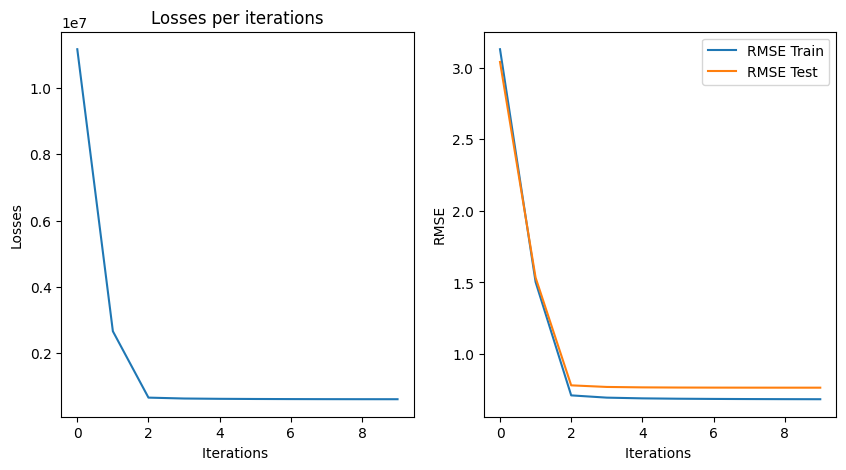

In [42]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(loss_with_latent)
plt.xlabel("Iterations ")
plt.ylabel("Losses")
plt.title("Losses per iterations")

plt.subplot(1,2,2)
plt.plot(rmse_train_with_latent, label="RMSE Train")
plt.legend()
plt.xlabel("Iterations ")
plt.ylabel("RMSE")
plt.plot(rmse_test_with_latent, label="RMSE Test")
plt.legend()
plt.xlabel("Iterations ")
plt.ylabel("RMSE")




plt.show()

##Saving weights and losses

In [43]:
np.savez(f"/content/drive/MyDrive/model_parameters_({k}_{lambda_}_{gamma}_{tau}).npz",
         rmse_train_losses=rmse_train_with_latent,
         rmse_test_losses=rmse_test_with_latent,
         train_losses=loss_with_latent,
         user_biases=user_biases,
         movie_biases=movie_biases,
         users_latent=U_matrix,
         movies_latent=V_matrix)

##Loading w/l

In [6]:
# Load the data
import numpy as np
import matplotlib.pyplot as plt

data = np.load("/content/drive/MyDrive/model_parameters_(20_0.1_0.1_1).npz")

# Access each parameter by key
rmse__train_losses = data['rmse_train_losses']
rmse_test_losses = data['rmse_test_losses']
train_losses = data['train_losses']
user_biases = data['user_biases']
movie_biases = data['movie_biases']
users_latent = data['users_latent']
movies_latent = data['movies_latent']


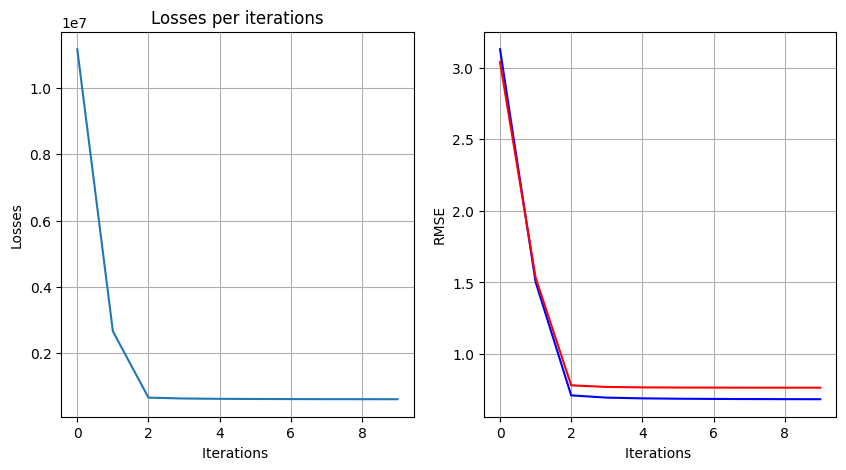

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses)
plt.xlabel("Iterations ")
plt.ylabel("Losses")
plt.title("Losses per iterations")
plt.grid(True)


plt.subplot(1,2,2)
plt.plot(rmse__train_losses, label="RMSE Train", color="blue")
plt.xlabel("Iterations ")
plt.ylabel("RMSE")
plt.plot(rmse_test_losses, label="RMSE Test", color="red")
plt.xlabel("Iterations ")
plt.ylabel("RMSE")
plt.grid(True)

plt.savefig("plot_latent_25m_try_2.pdf", format="pdf")
plt.show()

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
movies_latent[:5]

array([[ 0.39280555,  2.90031933,  0.73298075,  0.22094501,  0.61955621,
         1.69624128, -1.92011438, -0.43841828, -0.7060463 , -0.05378545,
        -2.14340776,  0.12107574,  0.18546442, -0.33297212, -1.34928738,
         1.47538038, -0.57511266,  2.37970971,  1.21599853,  1.06583945],
       [ 0.5843537 ,  1.87166285, -0.25859375, -0.60799092,  0.45110615,
         0.62480766, -0.0671926 , -0.08398703,  2.22442132,  0.0875626 ,
        -0.62147733,  1.03070467, -0.17266071, -0.89656614, -0.04295346,
         1.78290892, -1.33801115,  1.19245844,  1.91884674,  0.32481578],
       [ 0.79229667,  1.90810799, -0.35973663, -0.86450946,  0.52627069,
         0.30547657, -0.00624708, -0.07951502,  2.35727197, -0.01722148,
        -0.65829176,  0.90680014, -0.21257275, -0.87475605, -0.05561291,
         1.79761063, -1.36081633,  0.99853001,  1.90939744,  0.34273878],
       [ 0.92243139,  1.67531539, -0.05470709, -0.21248869,  0.76766065,
         0.409312  , -0.92145981,  0.03790149,  

In [31]:
movies_df = pd.read_csv("/content/ml-25m/movies.csv")

movies_df.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [32]:

def get_movie_name_and_id(movie_search_term):
  results = []
  for movie_id, movie_title in zip(movies_df['movieId'], movies_df['title']):
    if movie_search_term.lower() in movie_title.lower():
      results.append((movie_title, movie_id))
  return results


In [33]:
get_movie_name_and_id("harry")

[('When Harry Met Sally... (1989)', 1307),
 ('Deconstructing Harry (1997)', 1701),
 ('Trouble with Harry, The (1955)', 2184),
 ("Who's Harry Crumb? (1989)", 3387),
 ('Harry and the Hendersons (1987)', 3388),
 ("Let's Get Harry (1986)", 3389),
 ('With a Friend Like Harry... (Harry, un ami qui vous veut du bien) (2000)',
  4077),
 ('Dirty Harry (1971)', 4855),
 ("Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)",
  4896),
 ('Harry and Walter Go to New York (1976)', 5487),
 ('Harry Potter and the Chamber of Secrets (2002)', 5816),
 ('J. Gang Meets Dynamite Harry, The (Jönssonligan & DynamitHarry) (1982)',
  6089),
 ('Dumb and Dumberer: When Harry Met Lloyd (2003)', 6482),
 ('Harry Potter and the Prisoner of Azkaban (2004)', 8368),
 ('Harry and Tonto (1974)', 26324),
 ('Harry Potter and the Goblet of Fire (2005)', 40815),
 ('Tom, Dick and Harry (1941)', 47397),
 ('Harry Potter and the Order of the Phoenix (2007)', 54001),
 ('Harry Potter and th

In [56]:
lambda_ = 1
gamma = 0.1
k = 20
tau = 1
# dummy_user_data = [(8368,5.0)]
dummy_user_data = [(1,5.0)]

for i in range(10):
  dummy_user_bias = 0
  dummy_user_latent = np.zeros(k)
  bias = 0
  num_movies = 0
  for (movie_id, rating) in dummy_user_data:
      movie_index = movie_to_id[movie_id]
      bias += rating - np.dot(dummy_user_latent ,movies_latent[movie_index]) - movie_biases[movie_index]
      # dummy_user_latent += rating * movies_latent[movie_index]
      num_movies += 1
  dummy_user_bias = (lambda_ * bias)/((lambda_* num_movies)+ gamma)

  term2 = np.zeros(k)
  term1 = np.zeros((k,k))
  c = 0
  for (movie_id, rating) in dummy_user_data:
      movie_index = movie_to_id[movie_id]
      term2 += movies_latent[movie_index] * (rating - movie_biases[movie_index] - dummy_user_bias)
      term1 += np.outer(movies_latent[movie_index], movies_latent[movie_index])
      c+=1
  term2 = lambda_* term2
  term1 = lambda_* term1 + (tau * np.identity(k))
  dummy_user_latent = np.linalg.solve(term1, term2)


In [57]:

movie_dictionary = dict(zip(movies_df['movieId'], movies_df['title']))

In [77]:
# Get top recommendations for the dummy user
top_n_recommendations = 30  # Number of recommendations to display
recommended_movies = []

for movie_id, latent_vector in enumerate(movies_latent):
    # Calculate predicted rating
    predicted_rating = (
        0.05* movies_latent[movie_id]
        + np.dot(dummy_user_latent, latent_vector)
    )

    # Add the predicted rating and movie ID to recommendations list
    recommended_movies.append((predicted_rating[0], movie_id))

# Sort movies by predicted rating in descending order
recommended_movies.sort(reverse=True, key=lambda x: x[0])

# Display top N recommended movies
print(f"Top {top_n_recommendations} recommended movies for the dummy user:")
for rating, movie_id in recommended_movies[:top_n_recommendations]:
    for old, new in movie_to_id.items():
      if new == movie_id:
        movie_name = old
        break
    print(f"Movie ID: {movie_name}    ,      Title: {movie_dictionary[movie_name]}")

Top 30 recommended movies for the dummy user:
Movie ID: 1    ,      Title: Toy Story (1995)
Movie ID: 3114    ,      Title: Toy Story 2 (1999)
Movie ID: 78499    ,      Title: Toy Story 3 (2010)
Movie ID: 783    ,      Title: Hunchback of Notre Dame, The (1996)
Movie ID: 720    ,      Title: Wallace & Gromit: The Best of Aardman Animation (1996)
Movie ID: 745    ,      Title: Wallace & Gromit: A Close Shave (1995)
Movie ID: 364    ,      Title: Lion King, The (1994)
Movie ID: 2355    ,      Title: Bug's Life, A (1998)
Movie ID: 1148    ,      Title: Wallace & Gromit: The Wrong Trousers (1993)
Movie ID: 595    ,      Title: Beauty and the Beast (1991)
Movie ID: 60069    ,      Title: WALL·E (2008)
Movie ID: 588    ,      Title: Aladdin (1992)
Movie ID: 34    ,      Title: Babe (1995)
Movie ID: 4886    ,      Title: Monsters, Inc. (2001)
Movie ID: 6377    ,      Title: Finding Nemo (2003)
Movie ID: 2294    ,      Title: Antz (1998)
Movie ID: 594    ,      Title: Snow White and the Seven 

In [2]:
!git clone https://github.com/A-Midhat/Recommender_system_MF.git

fatal: destination path 'Recommender_system_MF' already exists and is not an empty directory.


In [4]:
!cp "Final_Recommender_system(25m).ipynb" Recommender_system_MF/

cp: cannot stat 'Final_Recommender_system(25m).ipynb': No such file or directory
